# Imports

In [10]:
#!pip install seaborn
#!pip install scikit-image
#!pip install opencv-python
#!pip install openpyxl
#!pip install xlrd

In [4]:
pwd

'/home/joel/ringity/doc/figures'

In [5]:
import os
import re
import cv2
import time
import tarfile
import requests
import numpy as np
import pandas as pd
import networkx as nx
import ringity as rng
import seaborn as sns
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET

from zipfile import ZipFile
from pathlib import Path
from itertools import combinations, product as iter_product
from skimage.metrics import mean_squared_error as mse
from scipy.spatial.distance import pdist, squareform

rng.set_theme()
DATA_DIR = Path("..") / "data"
EMPIRICALNET_DIR = DATA_DIR / "empirical_networks"
PLOTS_DIR = DATA_DIR / "plots"
RAWDATA_DIR = DATA_DIR / "raw_data"
BLUE = sns.color_palette()[0]

In [6]:
mkdir ../data/plots

mkdir: cannot create directory ‘../data/plots’: File exists


# Lipid co-regulation network

## Download data

### paths and URLs

In [7]:
LIPID_FOLDER = RAWDATA_DIR / "lipid_network"
LIPID_URL = "https://ars.els-cdn.com/content/image/1-s2.0-S0092867415006418-mmc3.xlsx"
LIPID_EXCEL_FILE = LIPID_FOLDER / "1-s2.0-S0092867415006418-mmc3.xlsx"
LIPID_CORR_FILE = LIPID_FOLDER / "lipid_corr.txt"
LIPID_GRAPH_FILE = EMPIRICALNET_DIR / "lipid.gml"

### download data

In [8]:
os.makedirs(LIPID_FOLDER, exist_ok=True)

r = requests.get(LIPID_URL, allow_redirects=True)
with open(LIPID_EXCEL_FILE, "wb") as f:
    f.write(r.content)

## Analysis

### calculate correlations

In [9]:
skiprows = [168]  # No data for C20 Sphingomyelin available

genes = [
    "sh:Sptlc2",
    "sh:CerS2",
    "sh:CerS6",
    "sh:Smpd1",
    "sh:Asah1",
    "sh:Ugcg",
    "sh:CLN3",
    "sh:Lyst",
    "sh:Ormdl1",
    #'sh:GFP'        #(green fluorescent protein) used to normalize data
]

lipid_excel_df = pd.read_excel(
    LIPID_EXCEL_FILE, header=1, index_col=0, skiprows=skiprows
)[genes]

lipid_corr_df = lipid_excel_df.T.corr()

### define thresholded network

In [10]:
mkdir ../data/empirical_networks/

mkdir: cannot create directory ‘../data/empirical_networks/’: File exists


In [11]:
c = 0.6  # threshold

# create (binary) network
D_lipid = 1 - lipid_corr_df.abs().values
G_lipid = nx.from_numpy_array(np.where(D_lipid < 1 - c, 1, 0))
G_lipid.remove_edges_from(nx.selfloop_edges(nx.Graph(G_lipid)))
# get lcc
G_lipid = G_lipid.subgraph(max(nx.connected_components(G_lipid), key=len))

nx.write_gml(G_lipid, LIPID_GRAPH_FILE)

pos = nx.spring_layout(G_lipid)

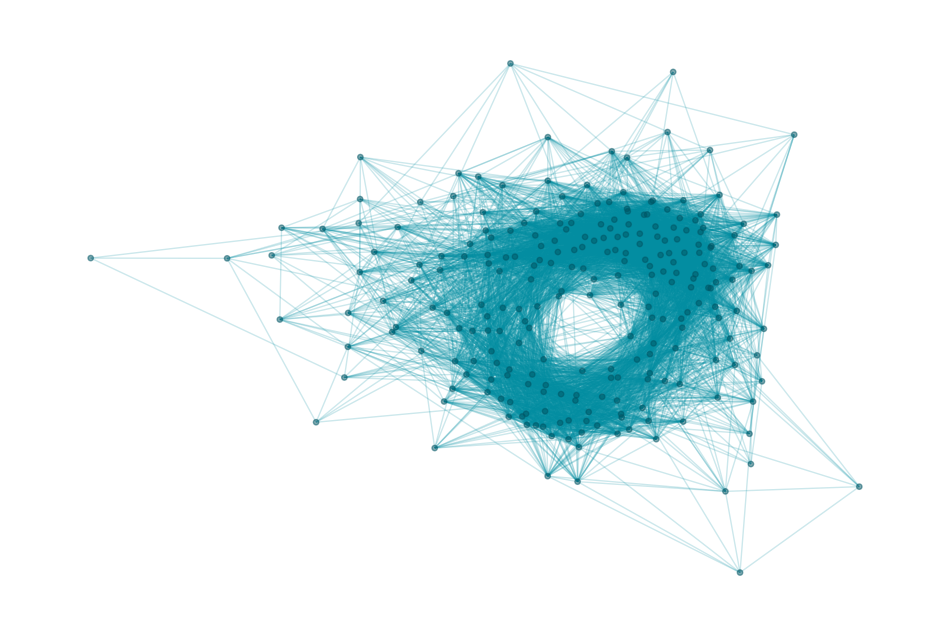

In [12]:
rng.plot_nx(G_lipid, pos=pos, node_alpha=0.5)

### degree distribution

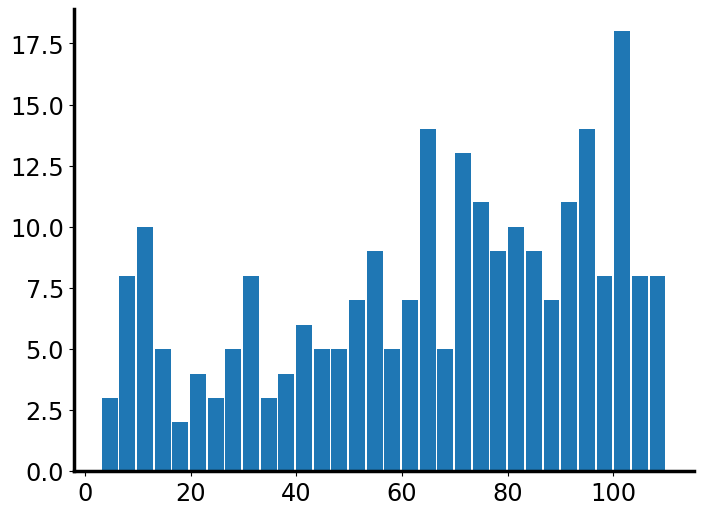

In [13]:
degree_sequence = sorted([d for n, d in G_lipid.degree()])
deg_fig, ax = plt.subplots(figsize=(8, 6))

degs, freqs, bars = ax.hist(degree_sequence, bins=2**5, rwidth=0.9, color=BLUE)

### persistence diagrams

In [14]:
dgm_lipid = rng.pdiagram(D_lipid, distance_matrix=True)
dgm_lipid_c = rng.pdiagram_from_network(G_lipid)

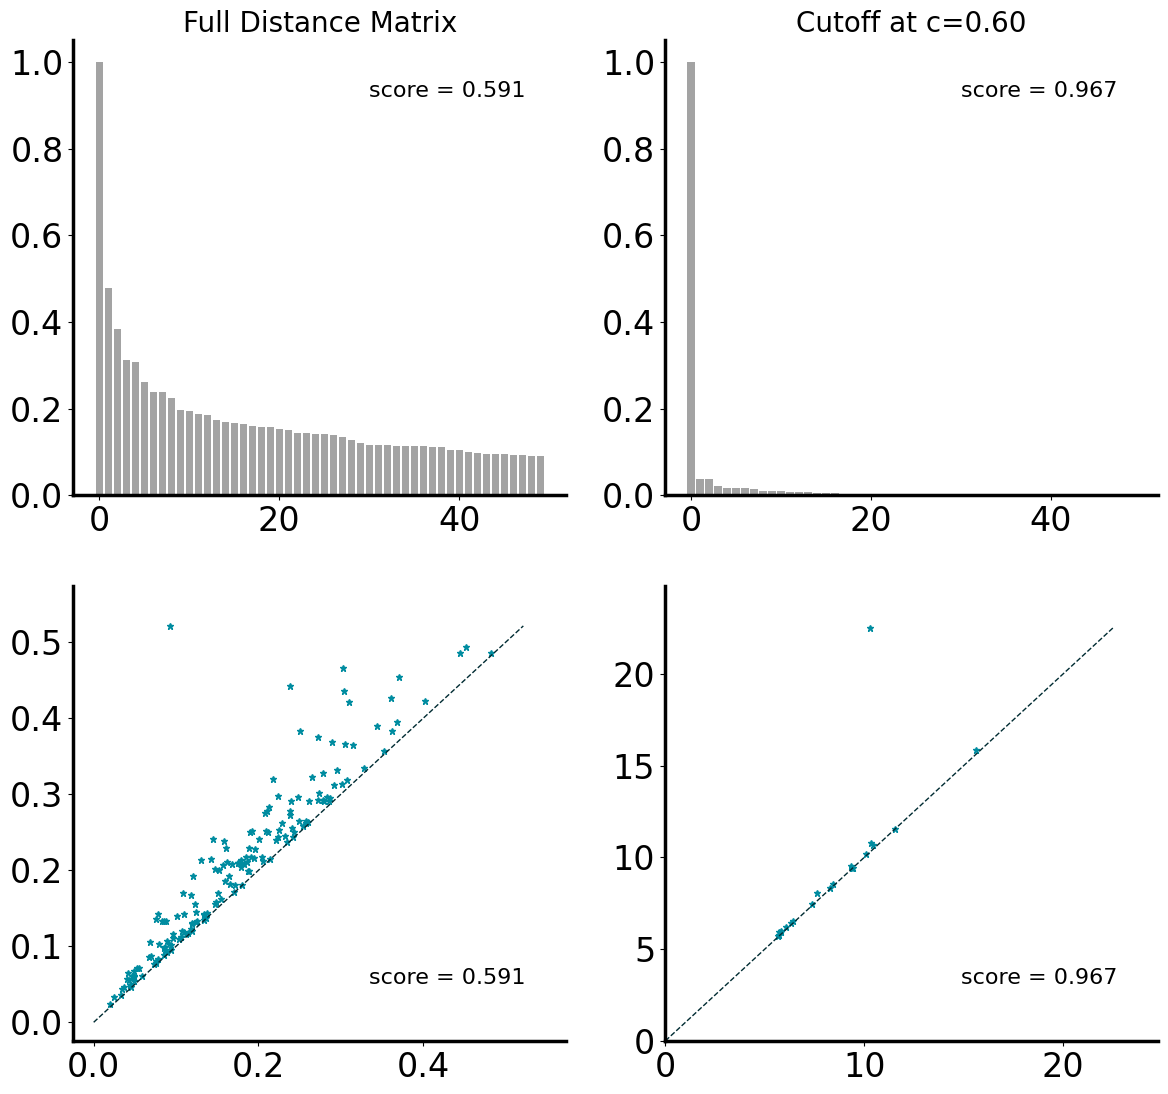

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 13))

axes[0, 0].set_title("Full Distance Matrix", fontsize=20)
axes[0, 1].set_title(f"Cutoff at c={c:.2f}", fontsize=20)

rng.plot_seq(dgm_lipid, ax=axes[0, 0], trim=50)
rng.plot_seq(dgm_lipid_c, ax=axes[0, 1], trim=50)
rng.plot_dgm(dgm_lipid, ax=axes[1, 0])
rng.plot_dgm(dgm_lipid_c, ax=axes[1, 1])

for nr, (ypos, pdgm) in enumerate(
    iter_product([0.875, 0.125], [dgm_lipid, dgm_lipid_c])
):
    anno = axes.flatten()[nr].annotate(
        f"score = {pdgm.ring_score():.3f}",
        xy=(0.6, ypos),
        xycoords="axes fraction",
        fontsize=16,
    )

### Summary statistics

In [16]:
N_lipid = nx.number_of_nodes(G_lipid)
M_lipid = nx.number_of_edges(G_lipid)
rho_lipid = nx.density(G_lipid)
d_lipid = nx.average_shortest_path_length(G_lipid)
c_lipid = nx.average_clustering(G_lipid)
s_lipid_w = dgm_lipid.ring_score()
s_lipid_u = dgm_lipid_c.ring_score()

print(f"Nodes N: {N_lipid}")
print(f"Links M: {M_lipid}")
print(f"Density rho: {rho_lipid:.3f}")
print(f"Distance d: {d_lipid:.3f}")
print(f"Clustering c: {c_lipid:.3f}")
print(f"Ring score S (weighted): {s_lipid_w:.3f}")
print(f"Ring score S (unweighted): {s_lipid_u:.3f}")

Nodes N: 244
Links M: 7974
Density rho: 0.269
Distance d: 1.830
Clustering c: 0.626
Ring score S (weighted): 0.591
Ring score S (unweighted): 0.967


## Save data

In [17]:
deg_fig.savefig(PLOTS_DIR / "Fig1-lipid-degreedist.pdf", transparent=True)
deg_fig.savefig(PLOTS_DIR / "Fig1-lipid-degreedist.png", transparent=True)

# Fibroblast proximity network

## Analysis

### paths

In [18]:
FIBRO_FOLDER = RAWDATA_DIR / "fibroblast_network"
FIBRO_FILE = FIBRO_FOLDER / "connectivity_FLS11_data.xls"
FIBRO_GRAPH_FILE = EMPIRICALNET_DIR / "fibro.gml"

name = "FLS18 TNF"

### define thresholded network

In [47]:
d = 115  # threshold

fibro_position_df = pd.read_excel(FIBRO_FILE, sheet_name=name)
# distance matrix
D_fibro = squareform(
    pdist(fibro_position_df[["Position X", "Position Y", "Position Z"]])
)

# create (unweighted) network
G_fibro = nx.from_numpy_array(np.where(D_fibro > d, 0, 1))
G_fibro.remove_edges_from(nx.selfloop_edges(nx.Graph(G_fibro)))

# get lcc, in case threshold was chosen too low
G_fibro = G_fibro.subgraph(max(nx.connected_components(G_fibro), key=len)).copy()

nx.write_gml(G_fibro, FIBRO_GRAPH_FILE)

pos = nx.spring_layout(G_fibro)

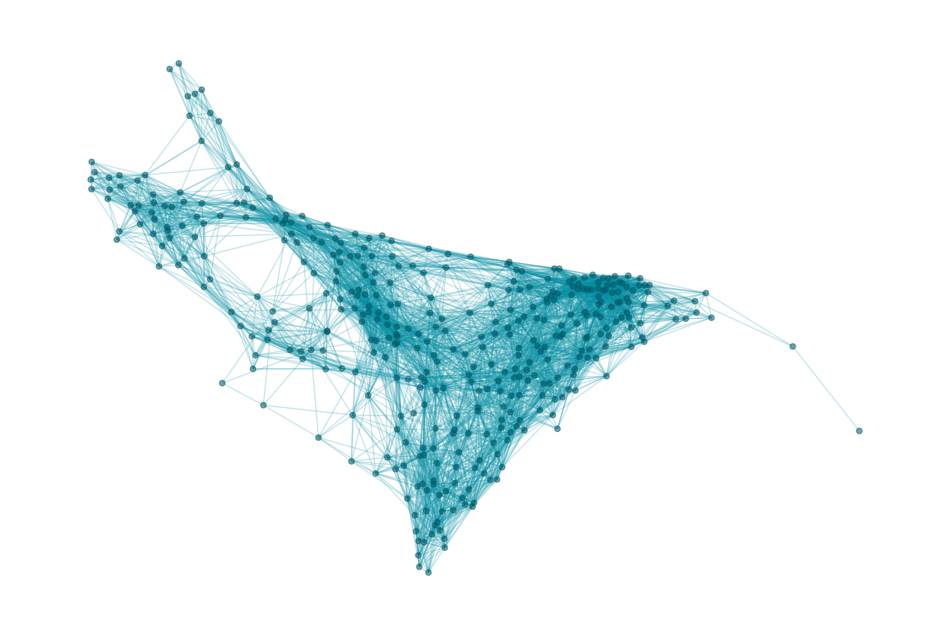

In [48]:
rng.plot_nx(G_fibro, pos=pos, node_alpha=0.5)

### degree distribution

In [38]:
degree_sequence = sorted([d for n, d in G_fibro.degree()])
deg_fig, ax = plt.subplots(figsize=(8, 6))

degs, freqs, bars = ax.hist(degree_sequence, bins=2**5, rwidth=0.9, color=BLUE)

NameError: name 'G_fibro' is not defined

### persistence diagrams

In [19]:
dgm_fibro = rng.pdiagram(D_fibro, distance_matrix=True)
dgm_fibro_d = rng.pdiagram(G_fibro)

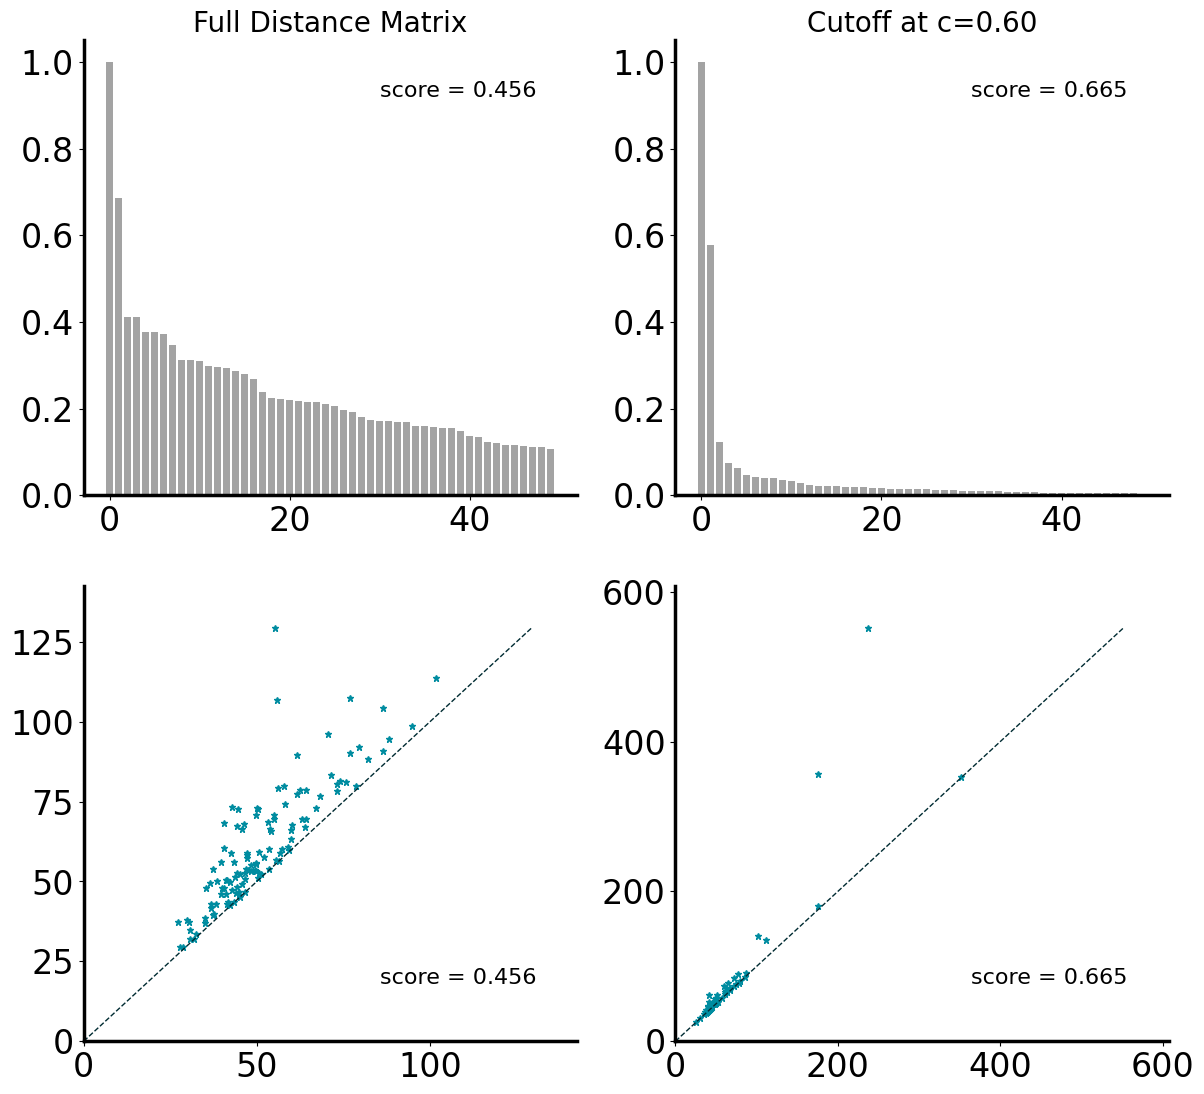

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 13))

axes[0, 0].set_title("Full Distance Matrix", fontsize=20)
axes[0, 1].set_title(f"Cutoff at c={c:.2f}", fontsize=20)

rng.plot_seq(dgm_fibro, ax=axes[0, 0], trim=50)
rng.plot_seq(dgm_fibro_d, ax=axes[0, 1], trim=50)
rng.plot_dgm(dgm_fibro, ax=axes[1, 0])
rng.plot_dgm(dgm_fibro_d, ax=axes[1, 1])

for nr, (ypos, pdgm) in enumerate(
    iter_product([0.875, 0.125], [dgm_fibro, dgm_fibro_d])
):
    anno = axes.flatten()[nr].annotate(
        f"score = {pdgm.ring_score():.3f}",
        xy=(0.6, ypos),
        xycoords="axes fraction",
        fontsize=16,
    )

### Summary statistics

In [21]:
N_fibro = nx.number_of_nodes(G_fibro)
M_fibro = nx.number_of_edges(G_fibro)
rho_fibro = nx.density(G_fibro)
d_fibro = nx.average_shortest_path_length(G_fibro)
c_fibro = nx.average_clustering(G_fibro)
s_fibro_w = dgm_fibro.ring_score()
s_fibro_u = dgm_fibro_d.ring_score()

print(f"Nodes N: {N_fibro}")
print(f"Links M: {M_fibro}")
print(f"Density rho: {rho_fibro:.3f}")
print(f"Distance d: {d_fibro:.3f}")
print(f"Clustering c: {c_fibro:.3f}")
print(f"Ring score S (weighted): {s_fibro_w:.3f}")
print(f"Ring score S (unweighted): {s_fibro_u:.3f}")

Nodes N: 403
Links M: 6866
Density rho: 0.085
Distance d: 3.816
Clustering c: 0.647
Ring score S (weighted): 0.456
Ring score S (unweighted): 0.665


## Save data

In [22]:
deg_fig.savefig(PLOTS_DIR / "Fig1-fibro-degreedist.pdf", transparent=True)
deg_fig.savefig(PLOTS_DIR / "Fig1-fibro-degreedist.png", transparent=True)

# Reactome networks

## Download and filter

### Paths and URLs

In [49]:
IMMUNE_FOLDER = RAWDATA_DIR / "immune_network"
IMMUNE_FILE = IMMUNE_FOLDER / "reactome_smbl.tgz"
IMMUNE_URL = "https://reactome.org/download/current/homo_sapiens.3.1.sbml.tgz"
IMMUNE_GRAPH_FILE = EMPIRICALNET_DIR / "immune.gml"

ROOT_DIR = IMMUNE_FOLDER / "homo_sapiens"

### download data

In [50]:
os.makedirs(IMMUNE_FOLDER, exist_ok=True)

# Download all human reactions from Reactome in SBML format
urllib.request.urlretrieve(IMMUNE_URL, IMMUNE_FILE)
tar = tarfile.open(IMMUNE_FILE)
tar.extractall(ROOT_DIR)
tar.close()

### choose parameters to filter databank

In [41]:
ringy_threshold = 0.6
min_nodes = 100

### extract ringy Reactome pathways

In [42]:
ringiy_graph_list = []
namespace = "{http://www.sbml.org/sbml/level3/version1/core}"

for nr, pathway_file in enumerate(os.listdir(ROOT_DIR), 1):
    print(f"{100*nr/len(os.listdir(ROOT_DIR)):.2f}%", end="\r")

    sbml = ET.parse(ROOT_DIR / pathway_file)

    model = sbml.getroot().find(namespace + "model")
    reactions = model.find(namespace + "listOfReactions")

    # List species annotated as "simple chemical" to remove them from networks,
    # to avoid creating star structures with the most common small molecules
    small_molecs = {
        term.attrib["id"]
        for term in model.find(namespace + "listOfSpecies")
        if term.attrib.get("sboTerm") == "SBO:0000247"
    }

    pathway_name = model.attrib["name"]
    pathway_ID = model.attrib["id"]

    # Create directed graph here
    G = nx.Graph(name=model.attrib["name"], id=model.attrib["id"])

    for reaction in reactions:

        list_of_products = reaction.find(namespace + "listOfProducts")
        list_of_reactants = reaction.find(namespace + "listOfReactants")

        if (not list_of_products) or (not list_of_reactants):
            continue

        products = {
            product.attrib["species"]
            for product in list_of_products
            if product.attrib["species"] not in small_molecs
        }
        reactants = {
            reagent.attrib["species"]
            for reagent in list_of_reactants
            if reagent.attrib["species"] not in small_molecs
        }

        # Add edge from reagents to products
        G.add_edges_from((r, p) for (r, p) in iter_product(reactants, products))

    if len(G.edges):
        H = G.subgraph(max(nx.connected_components(G), key=len)).copy()
        if len(H) < min_nodes:
            continue
        dgm = rng.pdiagram(H)
        if dgm.ring_score() >= ringy_threshold:
            ringiy_graph_list.append(H)
            print(G.name)
            print("#Nodes in graph: ", len(G))
            print("#Nodes in LCC:   ", len(H))
            print("ring-score:      ", round(dgm.ring_score(), 3))
            print()

KEAP1-NFE2L2 pathway
#Nodes in graph:  166
#Nodes in LCC:    162
ring-score:       0.689

0.40%

/tmp/ipykernel_4665/548553520.py:31: DeprecationWarning: Testing an element's truth value will raise an exception in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  if (not list_of_products) or (not list_of_reactants):


Homology Directed Repair
#Nodes in graph:  120
#Nodes in LCC:    115
ring-score:       0.617

Epigenetic regulation of gene expression
#Nodes in graph:  259
#Nodes in LCC:    137
ring-score:       0.724

HCMV Late Events
#Nodes in graph:  114
#Nodes in LCC:    114
ring-score:       0.693

Gastrulation
#Nodes in graph:  173
#Nodes in LCC:    115
ring-score:       0.787

Hemostasis
#Nodes in graph:  607
#Nodes in LCC:    182
ring-score:       0.891

Transcriptional regulation by RUNX1
#Nodes in graph:  208
#Nodes in LCC:    197
ring-score:       0.79

Signaling by Nuclear Receptors
#Nodes in graph:  332
#Nodes in LCC:    225
ring-score:       0.714

Adaptive Immune System
#Nodes in graph:  494
#Nodes in LCC:    128
ring-score:       0.647

Signaling by Interleukins
#Nodes in graph:  797
#Nodes in LCC:    398
ring-score:       0.601

Diseases of signal transduction by growth factor receptors and second messengers
#Nodes in graph:  635
#Nodes in LCC:    250
ring-score:       0.701

Signali

KeyboardInterrupt: 

## Analysis

### choose network to analyse

In [ ]:
graph_name = "Interferon Signaling"

(G_immune,) = [G for G in ringiy_graph_list if G.name == graph_name]

nx.write_gml(G_immune, IMMUNE_GRAPH_FILE)

pos = nx.spring_layout(G_immune)

In [ ]:
rng.plot_nx(G_immune, pos=pos, node_alpha=0.5)

### degree distribution

In [ ]:
degree_sequence = sorted([d for n, d in G_immune.degree()])
deg_fig, ax = plt.subplots(figsize=(8, 6))

degs, freqs, bars = ax.hist(degree_sequence, bins=2**5, rwidth=0.9, color=BLUE)

### persistence diagrams

In [ ]:
dgm_immune = rng.pdiagram(G_immune)

In [ ]:
fig, axes = plt.subplots(2, figsize=(7, 13))

axes[0].set_title(graph_name, fontsize=20)

rng.plot_seq(dgm_immune, ax=axes[0], trim=50)
rng.plot_dgm(dgm_immune, ax=axes[1])

for nr, ypos in enumerate([0.875, 0.125]):
    anno = axes[nr].annotate(
        f"score = {dgm_immune.ring_score():.3f}",
        xy=(0.7, ypos),
        xycoords="axes fraction",
        fontsize=16,
    )

### summary statistics

In [ ]:
N_immune = nx.number_of_nodes(G_immune)
M_immune = nx.number_of_edges(G_immune)
rho_immune = nx.density(G_immune)
d_immune = nx.average_shortest_path_length(G_immune)
c_immune = nx.average_clustering(G_immune)
s_immune_u = dgm_immune.ring_score()

print(f"Nodes N: {N_immune}")
print(f"Links M: {M_immune}")
print(f"Density rho: {rho_immune:.3f}")
print(f"Distance d: {d_immune:.3f}")
print(f"Clustering c: {c_immune:.3f}")
print(f"Ring score S (unweighted): {s_immune_u:.3f}")

## Save data

In [ ]:
deg_fig.savefig(PLOTS_DIR / 'Fig1-immune-degreedist.pdf', transparent=True)
deg_fig.savefig(PLOTS_DIR / 'Fig1-immune-degreedist.png', transparent=True)

# Gene expression network

## download data

### paths and URLs

In [51]:
GENE_FOLDER = RAWDATA_DIR / "gene_network/"
GENE_URL    = "https://www.dropbox.com/s/ms8k4kcga7j4uc0/circadiaNET_correlation_matrices.zip"
GENE_ZIP_FILE = GENE_FOLDER / "circadiaNET_correlation_matrices.zip"
GENE_GRAPH_FILE = EMPIRICALNET_DIR / "gene.gml"

### download data

For some reason this doesn't seem to work properly.   
Please manually download the zip-file from the `GENE_URL` into the `GENE_FOLDER` (after creating it).

In [52]:
os.makedirs(GENE_FOLDER, exist_ok=True)

# r = requests.get(GENE_URL, allow_redirects=True)
# with open(GENE_ZIP_FILE, 'wb') as f:
#     f.write(r.content)

### unzip data

In [53]:
# In case it is not unziped it already
GENE_FILENAME = (
    Path("circadiaNET_correlation_matrices")
    / "arabidopsis_thaliana_correlation_matrix.txt"
)
# with ZipFile(GENE_ZIP_FILE, 'r') as z:
#     z.extract(GENE_FILENAME, GENE_FOLDER)

## Analysis

### define thresholded network

In [57]:
c = 0.95

# get unweighted network
gene_corr_df = pd.read_csv(GENE_FOLDER / GENE_FILENAME, delimiter=" ")
# subsample for test-run
# gene_corr_df = gene_corr_df.drop(index=gene_corr_df.index[::10], 
#                                  columns=gene_corr_df.columns[::10])
G_gene = nx.from_numpy_array(np.where(gene_corr_df > c, 1, 0))
G_gene.remove_edges_from(nx.selfloop_edges(nx.Graph(G_gene)))

# get LCC
G_gene = G_gene.subgraph(max(nx.connected_components(G_gene), key=len))
G_gene = nx.convert_node_labels_to_integers(G_gene)

nx.write_gml(G_gene, GENE_GRAPH_FILE)

pos = nx.spring_layout(G_gene)


KeyboardInterrupt



In [ ]:
print(G_gene.number_of_nodes())

In [ ]:
rng.plot_nx(G_gene, pos=pos, node_alpha=0.5)

### degree distribution

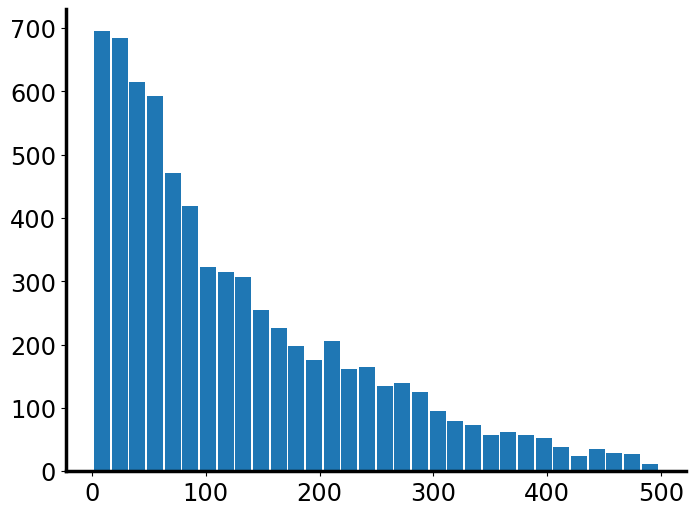

In [25]:
degree_sequence = sorted([d for n, d in G_gene.degree()])
deg_fig, ax = plt.subplots(figsize=(8, 6))

degs, freqs, bars = ax.hist(degree_sequence, bins=2**5, rwidth=0.9, color=BLUE)

6847

### persistence diagram

In [27]:
t1 = time.time()
D_gene = (1 - gene_corr_df).values  # calculate distance matrix
t2 = time.time()
print(f"Time to calculate distance matrix: {t2 - t1:.3f} sec")
dgm_gene = rng.pdiagram(D_gene, distance_matrix=True)
t3 = time.time()
print(f"Time to calculate persistence diagram with original weights: {t3 - t2:.3f} sec")
dgm_gene_c = rng.pdiagram(G_gene)
t4 = time.time()
print(f"Time to calculate persistence diagram of cutoff graph: {t4 - t3:.3f} sec")

Time to calculate distance matrix: 0.068 sec
Time to calculate persistence diagram with original weights: 385.788 sec
Time to calculate persistence diagram of cutoff graph: 40989.938 sec


In [62]:
40989.938 / (60*60)

11.38609388888889

NameError: name 'dgm_gene' is not defined

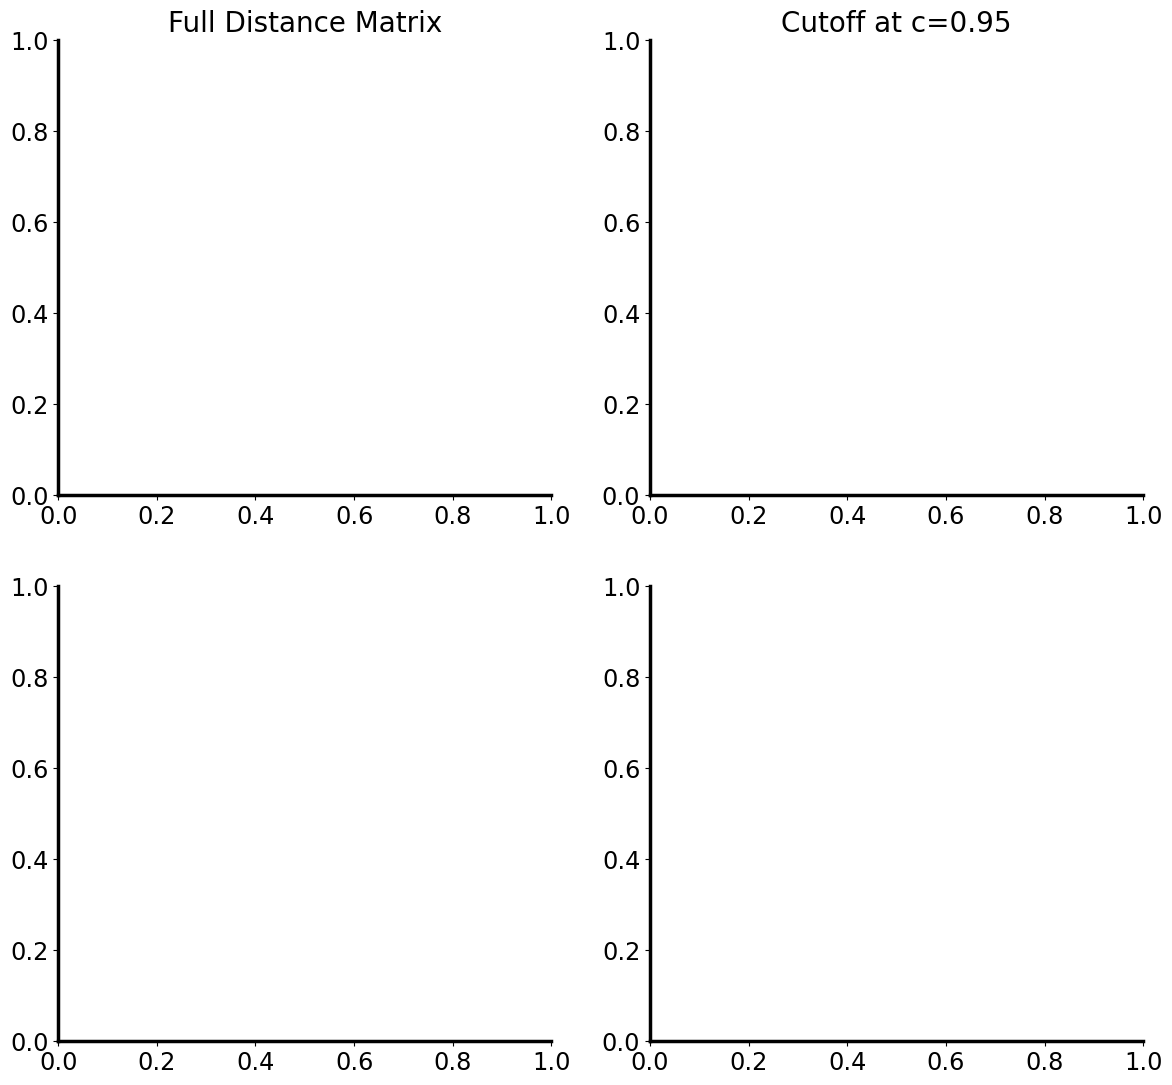

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(14, 13))

axes[0, 0].set_title("Full Distance Matrix", fontsize=20)
axes[0, 1].set_title(f"Cutoff at c={c:.2f}", fontsize=20)

rng.plot_seq(dgm_gene, ax=axes[0, 0], trim=50)
rng.plot_seq(dgm_gene_c, ax=axes[0, 1], trim=50)
rng.plot_dgm(dgm_gene, ax=axes[1, 0])
rng.plot_dgm(dgm_gene_c, ax=axes[1, 1])

for nr, (ypos, pdgm) in enumerate(iter_product([0.875, 0.125], [dgm_gene, dgm_gene_c])):
    anno = axes.flatten()[nr].annotate(
        f"score = {pdgm.ring_score():.3f}",
        xy=(0.6, ypos),
        xycoords="axes fraction",
        fontsize=16,
    )

### Summary statistics

In [29]:
N_gene = nx.number_of_nodes(G_gene)
M_gene = nx.number_of_edges(G_gene)
rho_gene = nx.density(G_gene)
d_gene = nx.average_shortest_path_length(G_gene)
c_gene = nx.average_clustering(G_gene)
s_gene_w = dgm_gene.ring_score()
s_gene_u = dgm_gene_c.ring_score()

print(f"Nodes N: {N_gene}")
print(f"Links M: {M_gene}")
print(f"Density rho: {rho_gene:.3f}")
print(f"Distance d: {d_gene:.3f}")
print(f"Clustering c: {c_gene:.3f}")
print(f"Ring score S (weighted): {s_gene_w:.3f}")
print(f"Ring score S (unweighted): {s_gene_u:.3f}")

Nodes N: 6847
Links M: 435174
Density rho: 0.019
Distance d: 6.492
Clustering c: 0.510
Ring score S (weighted): 0.884
Ring score S (unweighted): 0.777


## Save data

In [32]:
deg_fig.savefig(PLOTS_DIR / "Fig1-gene-degreedist.pdf", transparent=True)
deg_fig.savefig(PLOTS_DIR / "Fig1-gene-degreedist.svg", transparent=True)
deg_fig.savefig(PLOTS_DIR / "Fig1-gene-degreedist.png", transparent=True)

# Soil moisture network 

## download data

In [19]:
SOIL_FOLDER = RAWDATA_DIR / "soil_network"
SOIL_URL = "https://dlmultimedia.esa.int/download/public/videos/2017/11/002/orig-1711_002_AR_EN.mp4"
SOIL_MP4 = SOIL_FOLDER / "orig-1711_002_AR_EN.mp4"
SOIL_GRAPH_FILE = EMPIRICALNET_DIR / "soil.gml"

### download data

In [20]:
os.makedirs(SOIL_FOLDER, exist_ok=True)

r = requests.get(SOIL_URL, allow_redirects=True)
with open(SOIL_MP4, "wb") as f:
    f.write(r.content)

### extract frames from video

In [21]:
cap = cv2.VideoCapture(str(SOIL_MP4))
i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite(str(SOIL_FOLDER / f"img{i}.jpg"), frame)
    i += 1

cap.release()
cv2.destroyAllWindows()

## Analysis

### calculate pairwise $\texttt{mse}$

In [ ]:
pic_list = sorted(file for file in os.listdir(SOIL_FOLDER) if file.endswith("jpg"))

n = len(pic_list)

D_mse = np.zeros([n, n])

node2img = {}
for jpg in pic_list:
    node_id = int(*re.findall(r"\d+", jpg))
    img = mpimg.imread(f"{SOIL_FOLDER}/{jpg}", 0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    node2img[node_id] = img

t1 = time.time()
for i, (jpg_a, jpg_b) in enumerate(combinations(pic_list, 2)):
    node_a = int(*re.findall(r"\d+", jpg_a))
    node_b = int(*re.findall(r"\d+", jpg_b))

    D_mse[node_a, node_b] = mse(node2img[node_a], node2img[node_b])
    D_mse[node_b, node_a] = D_mse[node_a, node_b]

    t2 = time.time()
    print(f"{i/782.1:.3f}% - {t2-t1:.3f}sec", end="\r")

19.932% - 85.764sec

### define thresholded network

In [ ]:
d = 90

# get unweighted network
G_soil = nx.from_numpy_array(D_mse < d)
G_soil.remove_edges_from(nx.selfloop_edges(nx.Graph(G_soil)))

# get LCC
G_soil = G_soil.subgraph(max(nx.connected_components(G_soil), key=len))

nx.write_gml(G_soil, SOIL_GRAPH_FILE)

pos = nx.spring_layout(G_soil)

In [ ]:
rng.plot_nx(G_soil, pos=pos, node_alpha=0.5)

### degree distribution

In [ ]:
degree_sequence = sorted([d for n, d in G_soil.degree()])
deg_fig, ax = plt.subplots(figsize=(8, 6))

degs, freqs, bars = ax.hist(degree_sequence, bins=2**5, rwidth=0.9, color=BLUE)

### persistence diagrams

In [ ]:
dgm_soil = rng.pdiagram(D_mse, distance_matrix=True)
dgm_soil_d = rng.pdiagram(G_soil.copy())

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 13))

axes[0, 0].set_title("Full Distance Matrix", fontsize=20)
axes[0, 1].set_title(f"Cutoff at c={d:.2f}", fontsize=20)

rng.plot_seq(dgm_soil, ax=axes[0, 0], trim=50)
rng.plot_seq(dgm_soil_d, ax=axes[0, 1], trim=50)
rng.plot_dgm(dgm_soil, ax=axes[1, 0])
rng.plot_dgm(dgm_soil_d, ax=axes[1, 1])

for nr, (ypos, pdgm) in enumerate(iter_product([0.875, 0.125], [dgm_soil, dgm_soil_d])):
    anno = axes.flatten()[nr].annotate(
        f"score = {pdgm.ring_score():.3f}",
        xy=(0.6, ypos),
        xycoords="axes fraction",
        fontsize=16,
    )

## Summary statistics

In [ ]:
N_soil = nx.number_of_nodes(G_soil)
M_soil = nx.number_of_edges(G_soil)
rho_soil = nx.density(G_soil)
d_soil = nx.average_shortest_path_length(G_soil)
c_soil = nx.average_clustering(G_soil)
s_soil_w = dgm_soil.ring_score()
s_soil_u = dgm_soil_d.ring_score()

print(f"Nodes N: {N_soil}")
print(f"Links M: {M_soil}")
print(f"Density rho: {rho_soil:.3f}")
print(f"Distance d: {d_soil:.3f}")
print(f"Clustering c: {c_soil:.3f}")
print(f"Ring score S (weighted): {s_soil_w:.3f}")
print(f"Ring score S (unweighted): {s_soil_u:.3f}")

## Save data

In [ ]:
deg_fig.savefig(PLOTS_DIR / "Fig1-soil-degreedist.pdf", transparent=True)
deg_fig.savefig(PLOTS_DIR / "Fig1-soil-degreedist.png", transparent=True)